# <b> 0. IMPORTING LIBRARIES

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
# from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
import xml.etree.ElementTree as ET


In [2]:
%config Completer.use_jedi = False

# <b> 1. CREATING PATHS TO DIRECTORIES

In [3]:
#files path in a dictionary
paths = dict()
# Linux pc
paths['main'] = '/home/javi/Desktop/Python/MNIST_OD'
paths['dataset'] = os.path.join(paths['main'], 'MNIST_dataset')
paths['train_data'] = os.path.join(paths['dataset'], 'train')
paths['test_data'] = os.path.join(paths['dataset'], 'test')
# Windows pc
# paths['main'] = os.path.normcase('D:\Javi\Python\MNIST_OD')#.replace('\\','/'))
# paths['dataset'] = os.path.join(paths['main'], 'MNIST_dataset'))
# paths['train_data'] = os.path.join(paths['dataset'], 'train')
# paths['test_data'] = os.path.join(paths['dataset'], 'test')
# paths['test_img'] = os.path.join(paths['test_data'], 'test')

# <b> 2. CREATING THE YOLO LIKE MODEL

## 2.1 Neuronal network model

In [ ]:
class Yolo_Reshape(tf.keras.layers.Layer):
    def __init__(self, grid_size=7, no_bnb=2, no_class=10):
        super(Yolo_Reshape, self).__init__()
        self.grid_size = grid_size
        self.no_of_bnb = no_bnb
        self.no_class = no_class

    # def get_config(self):
    #     config = super().get_config().copy()
    #     config.update({
    #         'target_shape': self.target_shape
    #     })
    #     return config

    def call(self, inputs):
        # grids 7x7
        S = [self.grid_size, self.grid_size]
        # classes
        C = self.no_class
        # no of bounding boxes per grid
        B = self.no_of_bnb

        idx1 = S[0] * S[1] * C
        idx2 = idx1 + S[0] * S[1] * B

        # class probabilities
        class_probs = tf.reshape(inputs[:, :idx1], (tf.shape(inputs)[0],) + tuple([S[0], S[1], C]))
        class_probs = tf.nn.softmax(class_probs)

        #confidence
        confs = tf.reshape(inputs[:, idx1:idx2], (tf.shape(inputs)[0],) + tuple([S[0], S[1], B]))
        confs = tf.math.sigmoid(confs)

        # boxes
        boxes = tf.reshape(inputs[:, idx2:], (tf.shape(inputs)[0],) + tuple([S[0], S[1], B * 4]))
        boxes = tf.math.sigmoid(boxes)

        outputs = tf.concat([class_probs, confs, boxes], axis=3)
        return outputs

In [ ]:
class MNIST_YOLO(tf.keras.Model):
    def __init__(self, inpshape, bocks_info,
                 grid_size=7, no_of_bnb=2, no_class=10):
        super().__init__()
        self.nConvs = 0
        self.nBlocks = 0
        self.grid_size = grid_size
        self.no_of_bnb = no_of_bnb
        self.no_class = no_class
        self.bocks_info = bocks_info
        self.inpshape = inpshape
        self.layersList = list()
        for key, val in self.bocks_info.items():
            self.block_CN_gen(val, self.layersList)
        self.flatten = Flatten()
        self.dense_1 = Dense((self.no_class+self.no_of_bnb*5)*self.grid_size**2/4)
        self.drop =  Dropout(0.3)
        self.dense_2 = Dense((self.no_class+self.no_of_bnb*5)*self.grid_size**2, activation='sigmoid')
        # self.reshape = Reshape((self.grid_size, self.grid_size, self.no_class+self.no_of_bnb*5))
        self.final_conv = Conv2D(256, kernel_size=3, strides=1, activation='relu', name='conv2D_last')
        self.reshape = Yolo_Reshape(self.grid_size, self.no_of_bnb, self.no_class)

    def block_CN_gen(self, dictionary_info, layers_list):
        '''generate a block of convolutions
        dictionary_info : dict of list {kernel_list, stride_list, padding}'''
        for key, (filt, ker, stride, pad, act) in dictionary_info.items():
            layer_name = 'block{}_conv{}'.format(self.nBlocks, self.nConvs)
            layers_list.append(Conv2D(filt, kernel_size=ker, strides=stride, padding=pad,
                               activation=act, name=layer_name))
            self.nConvs += 1
        layers_list.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same',
                           name='Mpooling_block{}'.format(self.nBlocks)))
        self.nBlocks += 1

    def call(self, inputs):
        # inputs = self.InputLayer
        # x = self.A(inputs)#Input(shape=self.intshape)
        x = inputs
        for layer in self.layersList:
            x = layer(x)
        x = self.final_conv(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.drop(x)
        x = self.dense_2(x)
        x = self.reshape(x)
        return x#Model(inputs,x)
    def summary(self):
        inp = Input(shape=self.inpshape, name="input_layer")
        model = Model(inputs=[inp], outputs=self.call(inp))
        model.summary()
        del inp, model
        # return model.summary()
            
blocks_dict = {'block1':{'b1':[32, (7,7), (1,1), 'same', 'relu']},
               'block2':{'b1':[64, (3,3), (1,1), 'same', 'relu']},
               'block3':{'b1':[64, (1,1), (1,1), 'same', 'relu'], 'b2':[128, (3,3), (1,1), 'same', 'relu'],
                         'b3':[128, (1,1), (1,1), 'same', 'relu'], 'b4':[256, (3,3), (1,1), 'same', 'relu']},
               'block4':{'b1':[256, (1,1), (1,1), 'same', 'relu'], 'b2':[256, (3,3), (1,1), 'same', 'relu']}}
model = MNIST_YOLO(inpshape = (144,144,1),bocks_info=blocks_dict, grid_size=7, no_of_bnb=2, no_class=10)

print(model(tf.zeros([5,144,144,1])).shape)
model.summary()
print(model.predict(tf.zeros([5,144,144,1])).shape)

# inputs = Input(shape=(140,140,1))
# x = model(inputs)
# # print(x.numpy())
# output = Yolo_Reshape(grid_size=7, no_bnb=2, no_class=10)(x)

# mymodel = Model(inputs, output)
# mymodel.summary()
# class MyModel(tf.keras.Model):

#   def __init__(self):
#     super().__init__()
#     self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
#     self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

#   def call(self, inputs):
#     x = self.dense1(inputs)
#     return self.dense2(x)

# model = MyModel()

In [ ]:
# class ResnetIdentityBlock(tf.keras.Model):
#   def __init__(self, kernel_size, filters):
#     super(ResnetIdentityBlock, self).__init__(name='')
#     filters1, filters2, filters3 = filters

#     self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
#     self.bn2a = tf.keras.layers.BatchNormalization()

#     self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
#     self.bn2b = tf.keras.layers.BatchNormalization()

#     self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
#     self.bn2c = tf.keras.layers.BatchNormalization()
#     self.A = Dense(32)
#     self.flat = Flatten()

#   def call(self, input_tensor, training=False):
#     x = self.conv2a(input_tensor)
#     x = self.bn2a(x, training=training)
#     x = tf.nn.relu(x)

#     x = self.conv2b(x)
#     x = self.bn2b(x, training=training)
#     x = tf.nn.relu(x)

#     x = self.conv2c(x)
#     x = self.bn2c(x, training=training)

#     # x += input_tensor
#     x = (x)
#     x = self.A(x)
#     return tf.nn.relu(x)


# block = ResnetIdentityBlock(1, [1, 2, 3])
# _ = block(tf.zeros([1, 2, 3, 3]))
# block.summary()
# block.predict(tf.zeros([1,140,140,3]))

## 2.2 Creating a custom loss function

In [143]:
tensorA = np.arange(1*7*7*15).reshape([1,7,7,15])
tensorA = tf.Variable(tensorA)
tensorB = np.arange(1*7*7*15).reshape([1,7,7,15])*2
tensorB = tf.Variable(tensorB)
tf.math.reduce_sum(tf.subtract(tensorB,tensorA),axis=-1)

<tf.Tensor: shape=(1, 7, 7), dtype=int64, numpy=
array([[[  105,   330,   555,   780,  1005,  1230,  1455],
        [ 1680,  1905,  2130,  2355,  2580,  2805,  3030],
        [ 3255,  3480,  3705,  3930,  4155,  4380,  4605],
        [ 4830,  5055,  5280,  5505,  5730,  5955,  6180],
        [ 6405,  6630,  6855,  7080,  7305,  7530,  7755],
        [ 7980,  8205,  8430,  8655,  8880,  9105,  9330],
        [ 9555,  9780, 10005, 10230, 10455, 10680, 10905]]])>

In [125]:
class yolo_loss_function(tf.keras.losses.Loss):
    def __init__(self, grid_size, no_of_bnb, no_class):
        self.grid_size = grid_size
        self.no_of_bnb = no_of_bnb
        self.no_class = no_class
        self.coord_param = 0.5

    def call(self, y_true, y_pred):
        # True labels
        label_class = y_true[:,:,:,:self.no_class]
        label_box = y_true[:,:,:,self.no_class:self.no_class+4]
        response_mask = y_true[:,:,:,-1:]
        # Predicted labels
        pred_class = y_pred[:,:,:,:self.no_class]
        pred_trust = y_true[:,:,:,self.no_class:self.no_class+self.no_of_bnb]
        pred_box = y_true[:,:,:,self.no_class+self.no_of_bnb:]
        
        # Calculating the losses of the centers of the objects
        # coord * SUM(Iobj_i-j((x - xhat)² + (y - yhat)²))
        
        # Calculating the losses of the weith and heigth of the bb
        # coord * SUM(Iobj_i-j((w^0.5 - what^0.5)² + (h^0.5 - hhat^0.5)²))
        
        # Calculating the losses of the confidence in the predictions
        # SUM(Iobj_i-j((C - Chat)²)) + no_objt_param*SUM(Inoobj_i-j(h^0.5 - hhat^0.5)²)
        # Inoobj_i-j es de oposite of Iobj_i-j
        
        # Calculating the losses of the classes
        # SUM_everycell(SUM_classes((C - Chat)²))
        classes_loss = tf.math.reduce_sum(tf.multiply(response_mask, tf.math.reduce_sum(tf.subtract(label_class,pred_class),axis=-1)))
        # Calculating the total loss
        total_loss = classes_loss
        return total_loss

# class MeanSquaredError(Loss):
#     def call(self, y_true, y_pred):
#         return tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
# def xywh2minmax(xy, wh):
#     xy_min = xy - wh / 2
#     xy_max = xy + wh / 2

#     return xy_min, xy_max


# def iou(pred_mins, pred_maxes, true_mins, true_maxes):
#     intersect_mins = K.maximum(pred_mins, true_mins)
#     intersect_maxes = K.minimum(pred_maxes, true_maxes)
#     intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
#     intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

#     pred_wh = pred_maxes - pred_mins
#     true_wh = true_maxes - true_mins
#     pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
#     true_areas = true_wh[..., 0] * true_wh[..., 1]

#     union_areas = pred_areas + true_areas - intersect_areas
#     iou_scores = intersect_areas / union_areas

#     return iou_scores


# def yolo_head(feats):
#     # Dynamic implementation of conv dims for fully convolutional model.
#     conv_dims = K.shape(feats)[1:3]  # assuming channels last
#     # In YOLO the height index is the inner most iteration.
#     conv_height_index = K.arange(0, stop=conv_dims[0])
#     conv_width_index = K.arange(0, stop=conv_dims[1])
#     conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

#     # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
#     # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
#     conv_width_index = K.tile(
#         K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
#     conv_width_index = K.flatten(K.transpose(conv_width_index))
#     conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
#     conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
#     conv_index = K.cast(conv_index, K.dtype(feats))

#     conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

#     box_xy = (feats[..., :2] + conv_index) / conv_dims * 448
#     box_wh = feats[..., 2:4] * 448

#     return box_xy, box_wh


# def yolo_loss(y_true, y_pred):
#     label_class = y_true[..., :20]  # ? * 7 * 7 * 20
#     label_box = y_true[..., 20:24]  # ? * 7 * 7 * 4
#     response_mask = y_true[..., 24]  # ? * 7 * 7
#     response_mask = K.expand_dims(response_mask)  # ? * 7 * 7 * 1

#     predict_class = y_pred[..., :20]  # ? * 7 * 7 * 20
#     predict_trust = y_pred[..., 20:22]  # ? * 7 * 7 * 2
#     predict_box = y_pred[..., 22:]  # ? * 7 * 7 * 8

#     _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
#     _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

#     label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
#     label_xy = K.expand_dims(label_xy, 3)  # ? * 7 * 7 * 1 * 1 * 2
#     label_wh = K.expand_dims(label_wh, 3)  # ? * 7 * 7 * 1 * 1 * 2
#     label_xy_min, label_xy_max = xywh2minmax(label_xy, label_wh)  # ? * 7 * 7 * 1 * 1 * 2, ? * 7 * 7 * 1 * 1 * 2

#     predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2
#     predict_xy = K.expand_dims(predict_xy, 4)  # ? * 7 * 7 * 2 * 1 * 2
#     predict_wh = K.expand_dims(predict_wh, 4)  # ? * 7 * 7 * 2 * 1 * 2
#     predict_xy_min, predict_xy_max = xywh2minmax(predict_xy, predict_wh)  # ? * 7 * 7 * 2 * 1 * 2, ? * 7 * 7 * 2 * 1 * 2

#     iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)  # ? * 7 * 7 * 2 * 1
#     best_ious = K.max(iou_scores, axis=4)  # ? * 7 * 7 * 2
#     best_box = K.max(best_ious, axis=3, keepdims=True)  # ? * 7 * 7 * 1

#     box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  # ? * 7 * 7 * 2

#     no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_trust)
#     object_loss = box_mask * response_mask * K.square(1 - predict_trust)
#     confidence_loss = no_object_loss + object_loss
#     confidence_loss = K.sum(confidence_loss)

#     class_loss = response_mask * K.square(label_class - predict_class)
#     class_loss = K.sum(class_loss)

#     _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
#     _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

#     label_xy, label_wh = yolo_head(_label_box)  # ? * 7 * 7 * 1 * 2, ? * 7 * 7 * 1 * 2
#     predict_xy, predict_wh = yolo_head(_predict_box)  # ? * 7 * 7 * 2 * 2, ? * 7 * 7 * 2 * 2

#     box_mask = K.expand_dims(box_mask)
#     response_mask = K.expand_dims(response_mask)

#     box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
#     box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
#     box_loss = K.sum(box_loss)

#     loss = confidence_loss + class_loss + box_loss

#     return loss

## 2.3 Custom learning rate functions

In [ ]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    # (0, 0.01),
    # (75, 0.001),
    # (105, 0.0001),
    (0, 0.01),
    (15, 0.001),
    (25, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

# <b> 3. CREATING THE DATASET TO TRAIN THE NN

## 3.1 Pascal Voc reader

In [98]:
# This is the mapping function for the dataset. The dataset read the
# files of the directory and generate a list of paths, it will return
# a tupple with (image, data_info)

def pascal_voc_to_dict(filepath):
    """Function to get all the objects from the annotation XML file."""
    # The next 3 lines must be modify if the dataset or nn change:
    grid_size = 7
    no_class = 10
    no_of_bnb = 2

    with tf.io.gfile.GFile(filepath.numpy().decode(), "r") as f:
        # print(f.read())
        root = ET.parse(f).getroot()

        size = root.find("size")
        image_w = float(size.find("width").text)
        image_h = float(size.find("height").text)
        filePath = str(root.find("path").text)
        img = tf.io.read_file(filePath)
        img = tf.io.decode_jpeg(img, channels=1).numpy()/255.0
        # Setting up the output tensor
        y_true_tensor = np.zeros([grid_size, grid_size, no_class+5])

        for obj in root.findall("object"):
            # Get object's label name.
            label = int(obj.find("name").text)
            # Get objects' pose name.
            # pose = obj.find("pose").text.lower()
            # is_truncated = obj.find("truncated").text == "1"
            # is_difficult = obj.find("difficult").text == "1"
            bndbox = obj.find("bndbox")
            xmax = float(bndbox.find("xmax").text)
            xmin = float(bndbox.find("xmin").text)
            ymax = float(bndbox.find("ymax").text)
            ymin = float(bndbox.find("ymin").text)
            # Calculating the middle point of the image and
            # (h,w) adimensional -> [0,1]
            x = (xmin + xmax) / 2 / image_w
            y = (ymin + ymax) / 2 / image_h
            w = (xmax - xmin) / image_w
            h = (ymax - ymin) / image_h
            # Calculate the position of the center inside
            # of the grid (i,j) -> (x,y)
            loc = [grid_size * x, grid_size * y]
            loc_i = int(loc[1])
            loc_j = int(loc[0])
            y = loc[1] - loc_i
            x = loc[0] - loc_j

            if y_true_tensor[loc_i, loc_j, no_class+4] == 0:
                y_true_tensor[loc_i, loc_j, label] = 1
                y_true_tensor[loc_i, loc_j, no_class:no_class+4] = [x, y, w, h]
                y_true_tensor[loc_i, loc_j, no_class+4] = 1  # response

        return img, y_true_tensor

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


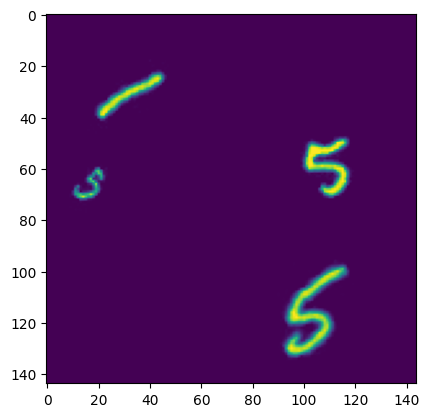

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


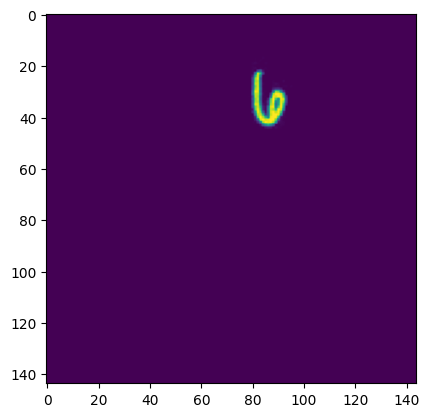

In [132]:
# files = os.listdir(paths['train_data'])
# files_xml = [paths['train_data']+'/'+x for x in files if x.endswith('.xml')]

# def map_images_from_path(path):
#     img = tf.io.read_file(path)
#     img = tf.io.decode_jpeg(img, channels=1)
#     return img
# data = tf.data.Dataset.from_tensor_slices(files_xml)

data = tf.data.Dataset.list_files(paths['train_data']+'/*.xml')
data = data.map(lambda x: tf.py_function(pascal_voc_to_dict,inp=[x],Tout=[tf.float32, tf.float32]))
# # data = data.map(lambda x: pascal_voc_to_dict(x.numpy().decode()))
tensor = list()
for x in data.take(2):
    print(x[1].numpy()[:,:,-1])#.numpy().decode()
    tensor.append(x[1])
    plt.imshow(x[0].numpy())
    plt.show()

In [135]:
# A = tf.ones([1,5,5,3])
# B = tf.multiply(A,2)
# tf.multiply(A,B)
A = tensor[0]
B = tensor[1]

TensorShape([7, 7, 15])

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
for i in data.take(1):
    print(i.numpy())

In [ ]:
img = tf.io.read_file(file_path)
plt.imshow(tf.io.decode_jpeg(img, channels=1).numpy(),cmap='gray')

In [ ]:
tf.keras.datasets.features.BBox(1,2,3,4)

In [ ]:
import tensorflow_datasets as tfds